# Modèle de **mélanges gaussiens** pour la génération de données
## 1 Modèle de mélange

* Soit $Z\in\{1,\dots,K\}$ telle que $\mathbb{P}[Z=k]=\pi_k$ avec $\sum_{k=1}^K\pi_k=1$ ;
* Soit $X\in\mathbb R^d$ telle que, conditionnellement à $Z=k$,  
  $$X\mid Z=k\;\sim\;\mathcal N(\mu_k,\Sigma_k)$$  
  où $\mu_k\in\mathbb R^d$ et $\Sigma_k\in\mathbb R^{d\times d}$ est définie positive.
* On considère un modèle de mélange de gaussien definit (pour un K fixé) par:
 $$\theta = (\boldsymbol{\pi}, \boldsymbol{\mu}, \boldsymbol{\Sigma}) = ((\pi_1, ..., \pi_K),(\mu_1, ..., \mu_K),(\Sigma_1, ..., \Sigma_K))$$


### T1
---  
On sait que $\mathbb{P}[Z=k] = \pi_k$

Soit $f_k(x;\mu_k,\Sigma_k) = \frac{1}{(2\pi)^{k/2}\,|\Sigma|^{1/2}}\,
\exp\!\bigl[-\tfrac12\,(x-\mu)^\top \Sigma^{-1}(x-\mu)\bigr],\qquad x \in \mathbb R$

Donc, $f_k(x;\mu_k,\Sigma_k) = f_{X\mid Z}(x\mid k)$
  
Par la loi totale de probabilité appliquée aux densités :

$f_X(x)=\sum_{k=1}^K \mathbb{P}[Z=k] \; f_{X\mid {Z = k}}(x)=\sum_{k=1}^K \pi_k\,\varphi_d(x;\mu_k,\Sigma_k).$
   
La somme finie de densités, pondérée par des poids positifs qui somment à 1, est bien une densité (positive partout et intégrale égale à 1).

### S1
---

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import math
import sklearn.datasets

rng = np.random.default_rng(42)

In [25]:
class GaussianMixtureModel:
    d: int
    weights: np.ndarray
    means: np.ndarray
    covariances: np.ndarray
    def __init__(self, d):
        self.d = d
    
    def set_params(self, weights, means, covariances):
        if len(means[0]) != self.d or len(covariances[0]) != self.d:
            raise ValueError(f"Length of weights, means, and covariances must match {self.d}.")
        if len(weights) != len(means) or len(weights) != len(covariances):
            raise ValueError("Weights, means, and covariances must have the same number of components.")
        self.weights = np.array(weights)
        self.means = np.array(means)
        self.covariances = np.array(covariances)

In [31]:
def plot_multivariate_normal(K, theta, n):
    Z = rng.choice(K, size=n, p=theta.weights) # K will be 1 unity less than the real index of the model 
    X = np.zeros((n, K - 1))
    for k in range(K):
        indices = np.where(Z == k)[0]
        for index in indices:
            X[index] = rng.multivariate_normal(theta.means[k], theta.covariances[k])
    return X, Z


Text(0.5, 1.0, 'Multivariate Normal Samples from GMM')

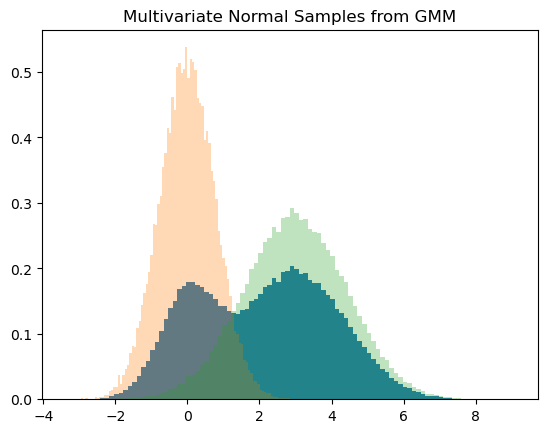

In [32]:
gmm = GaussianMixtureModel(d=1)
gmm.set_params(
    weights=[0.3, 0.7],
    means=[[0], [3]], 
    covariances=np.array([[[0.6]], [[2.0]]])
)
X, Z = plot_multivariate_normal(2, gmm, 100000)
plt.hist(X, bins=100, density=True)
X1 = X[Z == 0]
X2 = X[Z == 1]
plt.hist(X1, bins=100, density=True, alpha=0.3, label='Component 1')
plt.hist(X2, bins=100, density=True, alpha=0.3, label='Component 2')
plt.title('Multivariate Normal Samples from GMM')

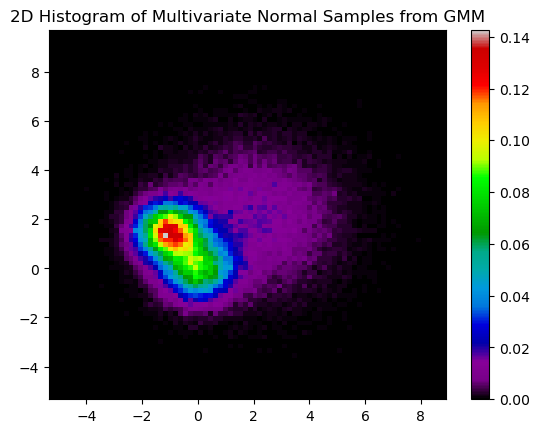

In [28]:
gmm = GaussianMixtureModel(d=2)
gmm.set_params(
    weights=[0.3, 0.3, 0.4],
    means=[[0, 0], [2, 2], [-1, 1.5]], 
    covariances=np.array([[[0.6, 0], [0, 0.6]], [[3.0, 0], [0, 3.0]], [[0.5, 0], [0, 0.5]]])
)
X, Z = plot_multivariate_normal(3, gmm, 100000)
# plt.hist(X[:,0], bins=100, density=True)
# plt.title('distribution of first dimension for d = 2')
# plt.show()
plt.hist2d(X[:,0], X[:,1], bins=(80,80), density=True, cmap = plt.cm.nipy_spectral)
plt.colorbar()
plt.title('2D Histogram of Multivariate Normal Samples from GMM')
plt.show()

## 2 Algorithme d'estimation

* Soit $Z\in\{1,\dots,K\}$ telle que $\mathbb{P}[Z=k]=\pi_k$ avec $\pi_k0$ et $\sum_{k=1}^K\pi_k=1$ ;
* Soit $X\in\mathbb R^d$ telle que, conditionnellement à $Z=k$,  
  $$X\mid Z=k\;\sim\;\mathcal N(\mu_k,\Sigma_k)$$  
  où $\mu_k\in\mathbb R^d$ et $\Sigma_k\in\mathbb R^{d\times d}$ est définie positive.
* On considère un modèle de mélange de gaussien definit (pour un K fixé) par:
 $$\theta = (\boldsymbol{\pi}, \boldsymbol{\mu}, \boldsymbol{\Sigma}) = ((\pi_1, ..., \pi_K),(\mu_1, ..., \mu_K),(\Sigma_1, ..., \Sigma_K))$$


In [ ]:
def vraisemblance(k, X, theta):
    vraisemblancePhi = np.zeros((len(X), k))
    for i in range(k):
        vraisemblancePhi[:, i] = multivariate_normal.pdf(X, mean=theta.means[i], cov=theta.covariances[i])
    vraisemblanceX = np.dot(vraisemblancePhi, theta.weights)
    vraisemblance = 0.0
    for i in range(len(vraisemblanceX)):
        vraisemblance += math.log(vraisemblanceX[i])

    return vraisemblance

In [47]:
def thetaEstimation(data, clusters, k):
    if len(clusters) != len(data):
        raise ValueError("The number of clusters must match the number of data points.")
    gmm = GaussianMixtureModel(X.shape[1])

    weights = np.zeros(k)
    for cluster in clusters:
        weights[cluster] += 1 / len(clusters)
    
    means = np.zeros((k, X.shape[1]))
    for i in range(data):
        means[clusters[i]] += data[i] / len(data)
    
    covariances = np.zeros((k, X.shape[1], X.shape[1]))
    for i in range(data):
        covariances[clusters[i]] = np.dot(data[i] - means[clusters[i]], data[i] - means[clusters[i]]) / len(data)


In [ ]:
def clustersEstimation(data, theta, k):
    

In [ ]:
data = sklearn.datasets.make_blobs(centers=3)
centres = data[0][:3]
zInitial = np.zeros(len(data[0]))
for i in range(len(data[0])):
    distances = np.zeros(len(centres))
    for j in range(len(centres)):
        distances[j] = np.linalg.norm(data[0][i] - centres)
    if distances[0] < distances[1] and distances[0] < distances[2]:
        zInitial[i] = 0
    elif distances[1] < distances[2]:
        zInitial[i] = 1
    else:
        zInitial[i] = 2
z = zInitial
for _ in range(15):
    theta = thetaEstimation(data[0], z, 3)
